In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 引入机器学习包，用于辅助pca及kmeans
from sklearn.preprocessing import StandardScaler
# PCA 引入
from sklearn.decomposition import PCA
# kmeans包
from sklearn.cluster import KMeans

In [3]:
# 引入处理后的准备聚类（J，Q）
excel_cluster = pd.ExcelFile("问题二将亚分类数据.xlsx")
excel_cluster.sheet_names

['高钾', '铅钡', '高钾权重', '铅钡权重']

In [4]:
data_J_clu = pd.read_excel(excel_cluster, "高钾")
data_Q_clu = pd.read_excel(excel_cluster, "铅钡")
data_J_wei = pd.read_excel(excel_cluster, "高钾权重")
data_Q_wei = pd.read_excel(excel_cluster, "铅钡权重")

In [5]:
# 获取经过特征选择后的数据
data_J_clu_af = data_J_clu[data_J_wei.columns.values].copy()
data_Q_clu_af = data_Q_clu[data_Q_wei.columns.values].copy()

In [6]:
scalar_J = StandardScaler()
scalar_J.fit(data_J_clu_af)

scalar_J_data = scalar_J.transform(data_J_clu_af)

pca_J = PCA(n_components=2,random_state=1)
pca_J.fit(scalar_J_data)

PCA(n_components=2, random_state=1)

In [7]:
x_pca = pca_J.transform(scalar_J_data)

In [8]:
pca_J.explained_variance_ratio_

array([0.50188699, 0.24723995])

In [10]:
pca_weight_J = (data_J_wei.values * np.absolute(pca_J.components_)).sum(axis=1)

In [11]:
pca_weight_J

array([0.47614854, 0.41181346])

In [13]:
x_pca_kmeans = x_pca*pca_weight_J

SSE = []
for k in range(1,9):
    estimator = KMeans(n_clusters=k)
    estimator.fit(x_pca_kmeans)
    SSE.append(estimator.inertia_)
pd.DataFrame(data=SSE)

,0
0,12.457283
1,6.329988
2,3.614984
3,2.243132
4,1.478013
5,0.725662
6,0.207249
7,0.092291


In [52]:
km_J = KMeans(n_clusters=3, random_state=4)
km_J.fit(x_pca_kmeans)
print(km_J.labels_)
data_J_clu["k-means_label"] = km_J.labels_

[1 0 1 1 0 1 1 1 1 2 2 2 1 0 1 1]


In [15]:
scalar_Q = StandardScaler()
scalar_Q.fit(data_Q_clu_af)

scalar_Q_data = scalar_Q.transform(data_Q_clu_af)

pca_Q = PCA(n_components=2,random_state=1)
pca_Q.fit(scalar_Q_data)

x_pca2 = pca_Q.transform(scalar_Q_data)

pca_weight_Q = (data_Q_wei.values * np.absolute(pca_Q.components_)).sum(axis=1)

In [16]:
pca_Q.explained_variance_ratio_

array([0.42137413, 0.27188246])

In [17]:
x_pca_kmeans2 = x_pca2*pca_weight_Q

SSE = []
for k in range(1,9):
    estimator = KMeans(n_clusters=k)
    estimator.fit(x_pca_kmeans2)
    SSE.append(estimator.inertia_)
pd.DataFrame(data=SSE)

,0
0,71.640564
1,34.455095
2,18.166557
3,11.947036
4,8.901333
5,6.687894
6,4.764034
7,3.324762


In [18]:
km_Q = KMeans(n_clusters=4, random_state=4)
km_Q.fit(x_pca_kmeans2)
print(km_Q.labels_)
data_Q_clu["k-means_label"] = km_Q.labels_

[2 0 0 3 0 1 0 2 0 2 2 2 2 2 2 2 2 2 3 2 2 2 3 1 3 1 1 2 1 1 3 3 3 3 1 3 2
 3 3 3]


In [22]:
writer_kmeans = pd.ExcelWriter("问题二聚类结果.xlsx")
data_J_clu.to_excel(writer_kmeans, "高钾")
data_Q_clu.to_excel(writer_kmeans, "铅钡")

In [23]:
writer_kmeans.save()
writer_kmeans.close()

In [24]:
data_J_clu_af.columns

Index(['氧化钠(Na2O)', '氧化钾(K2O)', '氧化钙(CaO)', '氧化铜(CuO)', '氧化钡(BaO)'], dtype='object')

In [25]:
# 保存主成分的参数值
pca_can_J = pd.DataFrame(data=pca_J.components_, columns = data_J_clu_af.columns)
pca_can_Q = pd.DataFrame(data=pca_Q.components_, columns = data_J_clu_af.columns)
writer_PCA = pd.ExcelWriter("问题二中pca参数结果.xlsx")
pca_can_J.to_excel(writer_PCA, "高钾")
pca_can_Q.to_excel(writer_PCA, "铅钡")
writer_PCA.save()
writer_PCA.close()

In [105]:
# 做kmeans聚类图
km_toP_J = pd.DataFrame(data=x_pca_kmeans, columns=["one","two"])
km_toP_Q = pd.DataFrame(data=x_pca_kmeans2, columns=["one","two"])

km_toP_J["kmeans"] = km_J.labels_

km_toP_Q["kmeans"] = km_Q.labels_ + 1

km_toP_J

from plotnine import *
base_plot2 = (ggplot(km_toP_Q, aes('one', 'two', color='factor(kmeans)')) +
              geom_point(alpha=0.4) +
              # 绘制透明度为0.2 的散点图
              stat_ellipse(aes(x='one', y='two', fill='factor(kmeans)'), geom="polygon", level=0.95, alpha=0.2) +
              # 绘制椭圆标定不同类别，如果省略该语句，则绘制图3-1-7(c)
              # 使用不同颜色标定不同数据类别
              scale_color_manual(values=("#9B559B", "#FC4E07","#00A5FF","#82C143")) +
              # 使用不同颜色标定不同椭类别
              scale_fill_manual(values=("#9B559B", "#FC4E07","#00A5FF","#82C143")) +
              xlim(-2,7) + 
              theme(
                    # text=element_text(size=15,face="plain",color="black"),
                    axis_title=element_text(size=18, face="plain", color="black"),
                    axis_text=element_text(size=16, face="plain", color="black"),
                    aspect_ratio=0.6,
                    figure_size=(5, 5),
                    dpi=1000
                )
)

# writer_k_P = pd.ExcelWriter("问题二用于聚类作图.xlsx")
# km_toP_J.to_excel(writer_k_P, "高钾")
# km_toP_Q.to_excel(writer_k_P, "铅钡")
# writer_k_P.save()
# writer_k_P.close()


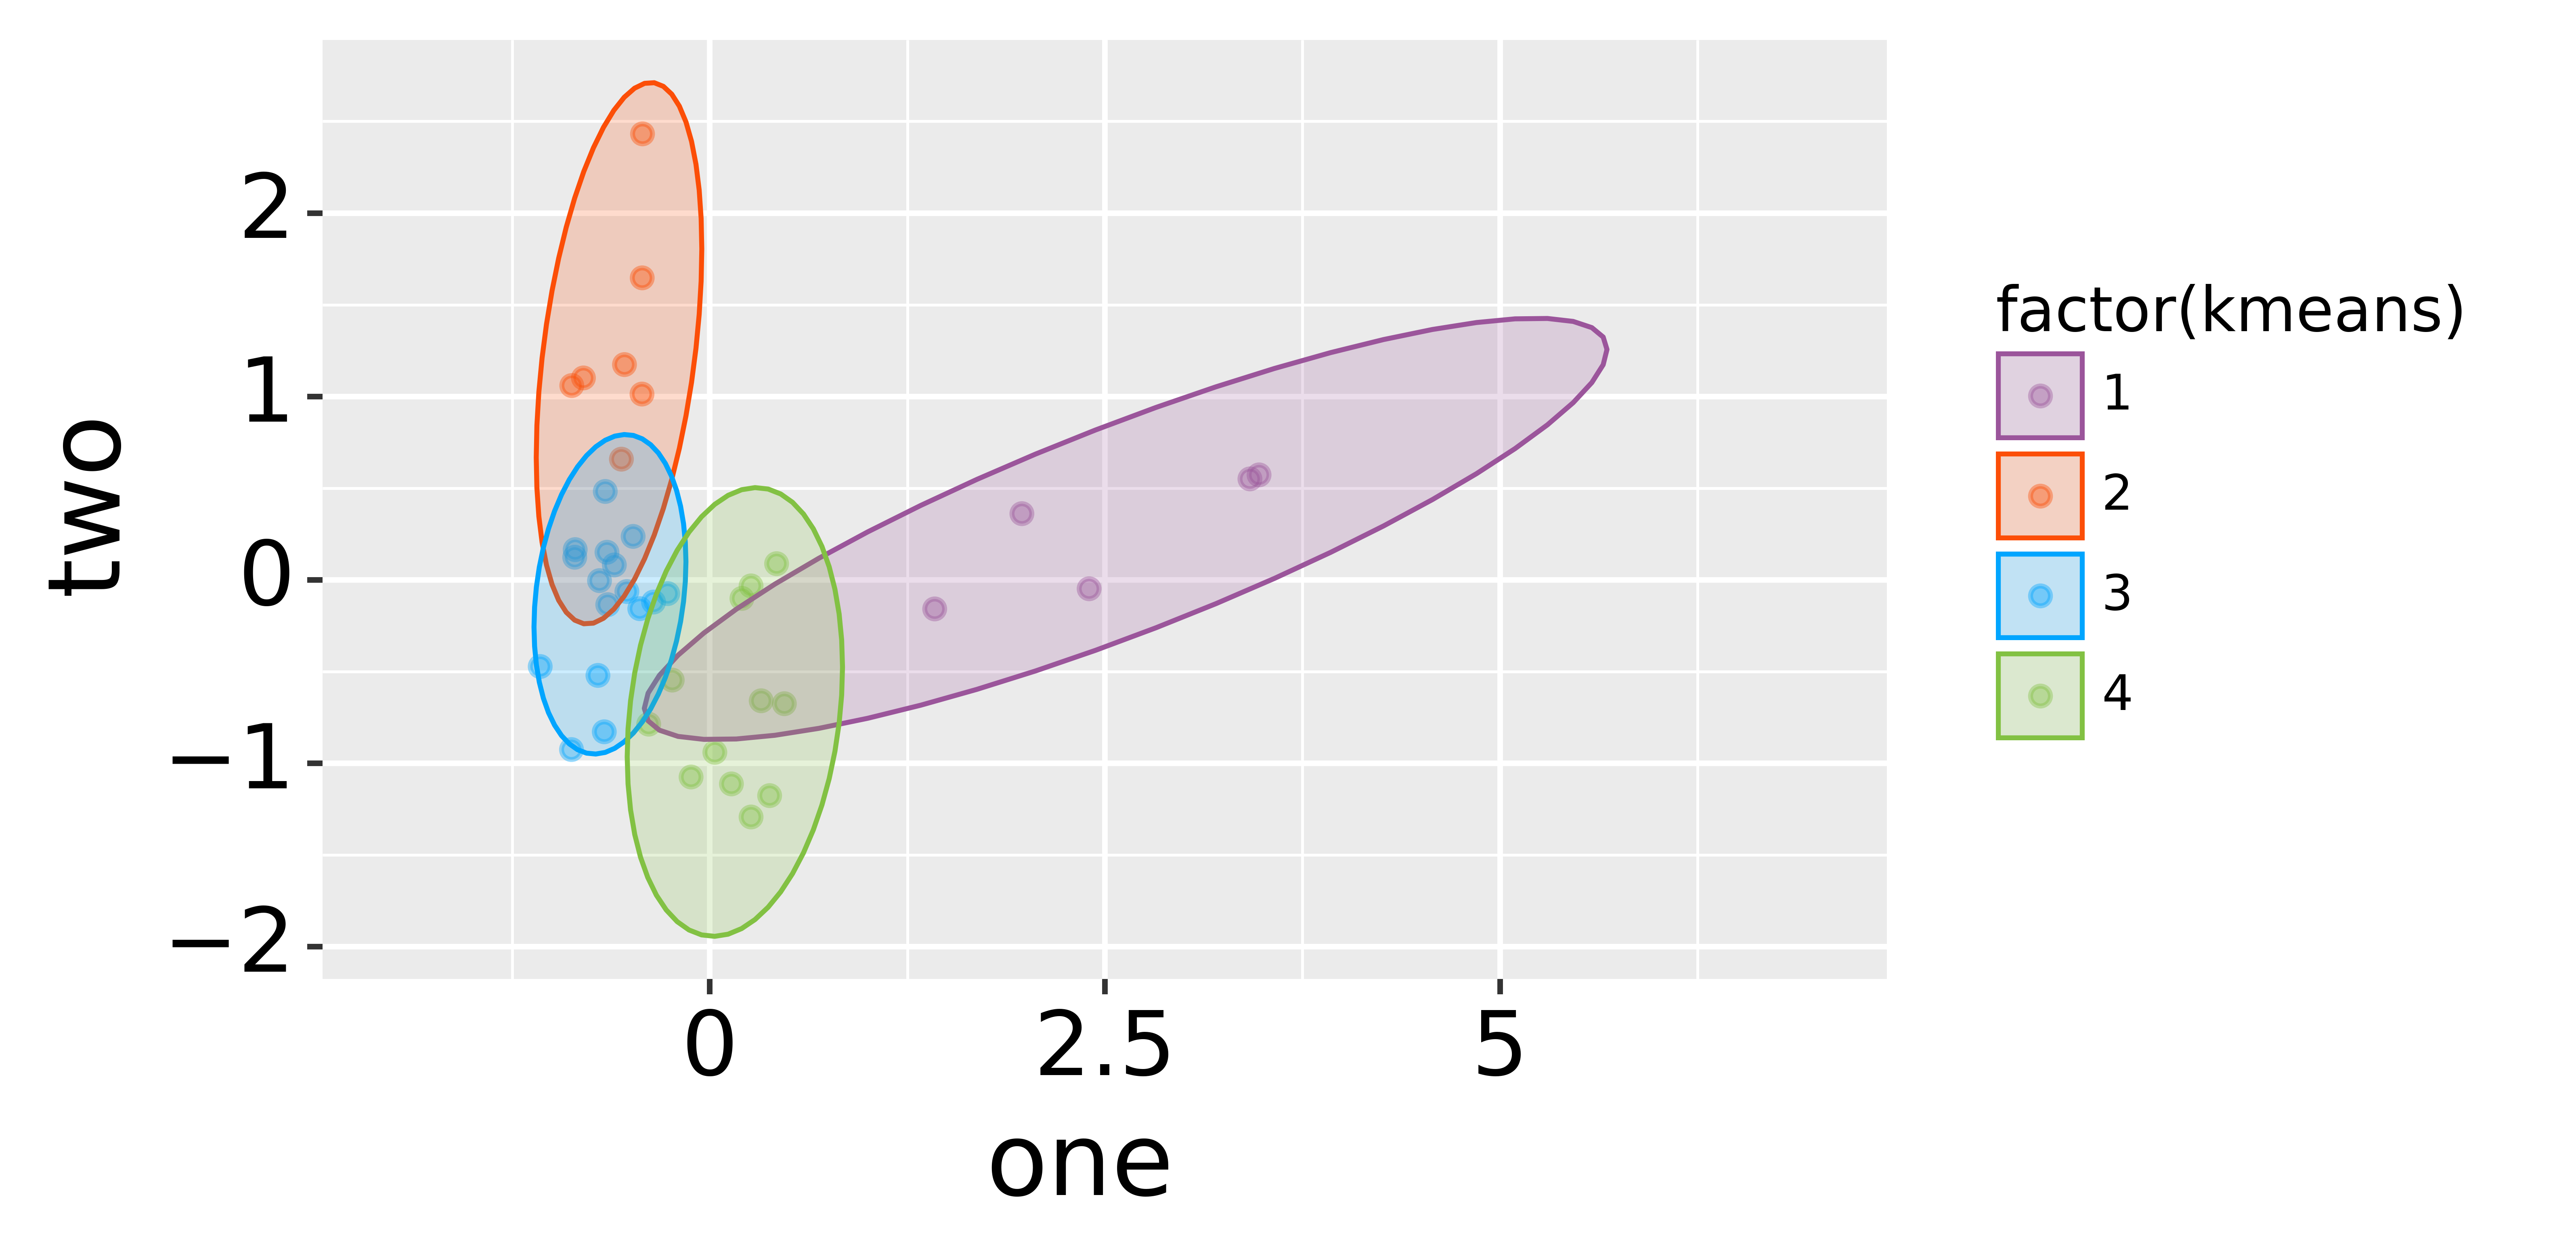

In [106]:
print(base_plot2)